### Overview: 
Cleaning and exploration of dataset containing information from Boardgame Geek as well as prices from webscraping. The varying mechanics found across the games were one-hot encoded. 
There was very little correlation found between any of the features within the dataset. 
#### Regression Problem:
A multi-layered perceptron and a random forest were then trained on the data to predict the price of the boardgames based off their data on Boardgame Geek. Neither models' performance was particularly accurate, with an average absolute mean error between £9-10. Whilst this is sufficient to give a rough guide to the cost of a game, it is not adequate to provide an insight as to whether you might be paying more or less than the game is worth when purchasing a game in real life. This inaccuracy is likely due to the data found on Boardgame Geek lacking key features that provide a clearer indication of a games price. Specifically, the quality and quantity of components. Whilst there is fluctuation in price to do the popularity of a game, a key factor is simply how much it costs to make, which unfortunately the BGG data does not provide.  

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split

In [3]:
df = pd.read_excel("updated_df.xlsx")
cleaned_df = df.copy()

In [4]:
def config_colour(plotted_values, colour_values, small_num = 10e-10, colour_scheme = 'viridis'):
    
    normalised_val = (sorted(colour_values) - min(colour_values))/(max(colour_values) - min(colour_values))

    normalised_val[0] += small_num
    normalised_val[-1] -= small_num
    idx = np.argsort(plotted_values)
    normalised_val = normalised_val[idx]
    
    change_to_colour = plt.get_cmap(colour_scheme)
    
    return change_to_colour(normalised_val)

## Data Cleaning / Feature Engineering

#### Examining distribution of games features:

In [5]:
df.head()

,ID,Name,Year,Rank,Bayes average,average,averageweight,boardgamemechanic,maxplayers,maxplaytime,minage,minplayers,minplaytime,numcomments,numweights,owned,playingtime,stddev,usersrated,price
0,174430,Gloomhaven,2017,1,8.611,8.89906,3.7930,"['Campaign / Battle Card Driven', 'Cooperative...",4,120,12,1,60,4995,1082,41470,120,1.60270,25289,88.95
1,161936,Pandemic Legacy: Season 1,2015,2,8.489,8.64165,2.8284,"['Action Point Allowance System', 'Cooperative...",4,60,13,2,60,4984,874,49878,60,1.60713,31326,51.73
2,182028,Through the Ages: A New Story of Civilization,2015,3,8.258,8.53104,4.3714,"['Action Point Allowance System', 'Auction/Bid...",4,120,14,2,120,2309,770,19551,120,1.49173,15835,36.95
3,167791,Terraforming Mars,2016,4,8.242,8.40331,3.2397,"['Card Drafting', 'Hand Management', 'Set Coll...",5,120,12,1,120,5932,1452,50512,120,1.36045,39327,46.99
4,12333,Twilight Struggle,2005,5,8.175,8.32253,3.5660,"['Area Control / Area Influence', 'Campaign / ...",2,180,13,2,120,7757,3251,47495,180,1.58575,34535,37.50


In [6]:
features_to_examine = [i for i in df]
to_remove = ['Name', 'ID', 'boardgamemechanic']
for j in to_remove:
    features_to_examine.remove(j)
print(features_to_examine)

['Year', 'Rank', 'Bayes average', 'average', 'averageweight', 'maxplayers', 'maxplaytime', 'minage', 'minplayers', 'minplaytime', 'numcomments', 'numweights', 'owned', 'playingtime', 'stddev', 'usersrated', 'price']


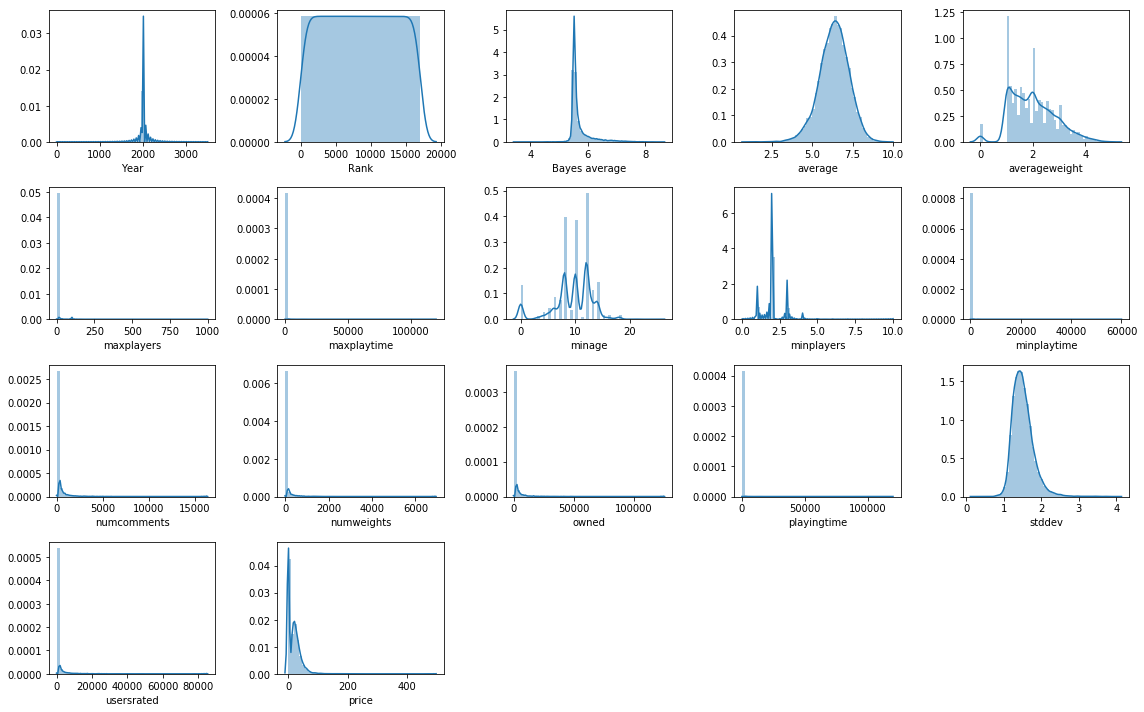

In [7]:
fig = plt.figure(figsize = (16, 10))
j = 0
for feat in features_to_examine: 
    plt.subplot(4, 5, j + 1)
    j += 1
    sns.distplot(df[feat])
fig.tight_layout()
plt.show()

It can be seen that outside the features that have bounded values (eg. average, averageweight), a lot of the measurements show a massive range of values. Part of the issue in this is that some are boundless. For instance, some games can take an endless amount of time without ever starting a new game, thus the Max Play Time is set to something outrageous like 120000 minutes. 


Other issues: 
* Weight seems to span 1-5 opposed to 0-5, with no games taking on a value 0<value<1. 
* Price - Has a funny distribution as it is including the games that a price was not found for.
* Max Players and Min/Max Playtime - both cater to games which have an unbounded number of players/play length without a consistent 
* Boardgames with years in the future

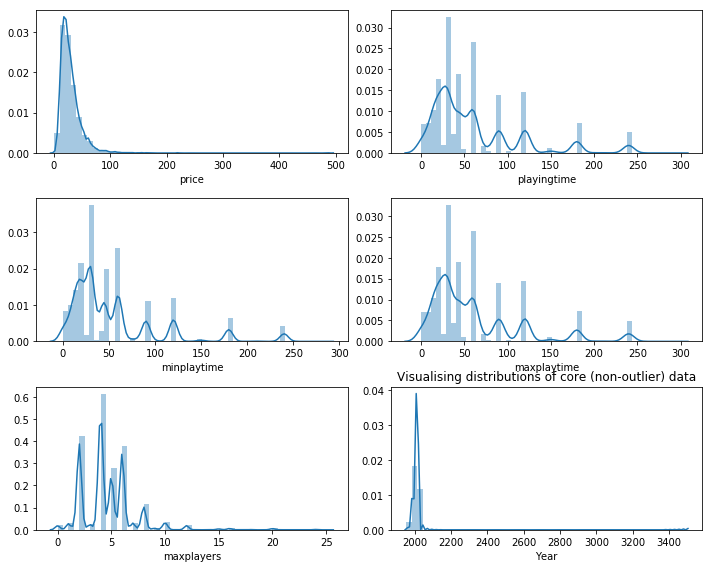

In [8]:
# Examining what the distributions might look like with outliers accounted for

fig = plt.figure(figsize = (10, 8))
rows = 3
cols = 2

plt.subplot(rows, cols, 1)
sns.distplot(df[df["price"] > 0].price)

plt.subplot(rows, cols, 2)
sns.distplot(df[df["playingtime"] < 300].playingtime)

plt.subplot(rows, cols, 3)
sns.distplot(df[df["minplaytime"] < 300].minplaytime)

plt.subplot(rows, cols, 4)
sns.distplot(df[df["maxplaytime"] < 300].maxplaytime)

plt.subplot(rows, cols, 5)
sns.distplot(df[df["maxplayers"] < 30].maxplayers)

plt.subplot(rows, cols, 6)
sns.distplot(df[df["Year"] > 1950 ].Year)

plt.tight_layout()
plt.title("Visualising distributions of core (non-outlier) data")
plt.show()

### Games with prices found

In [9]:
# Only interested in games which have a price associated. 
cleaned_df = cleaned_df[cleaned_df.price > 0]

### Game Age

In [10]:
current_year = 2020
print("Number of games made, apparently, in the future: {}".format(len(cleaned_df[cleaned_df.Year > current_year])))
cleaned_df[cleaned_df.Year > current_year].head()

Number of games made, apparently, in the future: 3


,ID,Name,Year,Rank,Bayes average,average,averageweight,boardgamemechanic,maxplayers,maxplaytime,minage,minplayers,minplaytime,numcomments,numweights,owned,playingtime,stddev,usersrated,price
134,188,Go,2200,135,7.357,7.64399,3.9909,['Area Enclosure'],2,180,8,2,30,3412,1314,17915,180,1.91083,13238,18.59
1178,2397,Backgammon,3000,1179,6.363,6.52820,2.0207,"['Betting/Wagering', 'Dice Rolling', 'Roll / S...",2,30,8,2,30,2758,868,15192,30,1.59618,10303,10.61
6242,2399,Senet,3500,6243,5.605,5.91536,1.4833,"['Dice Rolling', 'Roll / Spin and Move']",2,30,6,2,30,269,60,1143,30,1.60037,560,28.23


It can be seen that the games that are apparently built in the future are actually some of the oldest games in history. The error has likely arisen due to the dataset not taking into account AD vs BC with the year.
The way I plan on resolving this is through making their Year negative. 

In [11]:
# Converting it to BC Year
cleaned_df.Year = cleaned_df.Year.apply(lambda x: -x if x > current_year else x)

When looking at the distribution still it is wildly split. To make a cleaner distribution, the model is going to focus on "modern" boardgames, that is, anything released after 1950. 

In [12]:
# Dropping older games
year_cap = 1950

cleaned_df = cleaned_df.drop(cleaned_df[cleaned_df.Year < year_cap].index)

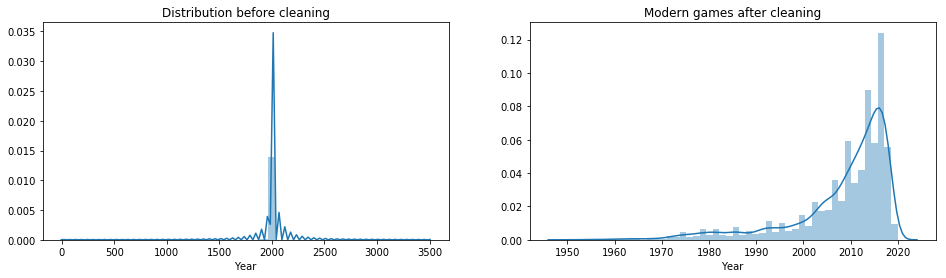

In [13]:
fig = plt.figure(figsize = (16, 4))
plt.subplot(1, 2, 1)
sns.distplot(df.Year)
plt.title("Distribution before cleaning")

plt.subplot(1, 2, 2)
plt.title("Modern games after cleaning")
sns.distplot(cleaned_df.Year)
plt.show()

### Max Players

In [14]:
player_count_cap = 30
max_players_df = cleaned_df[cleaned_df.maxplayers > player_count_cap]
print("Number of games that can play with more than {} players: {}".format(player_count_cap, len(max_players_df)))

Number of games that can play with more than 30 players: 68


There are plenty of games which can play with an apparently boundless number of people. These are often party games catering to larger groups. Unfortunately, some of these games have been labeled inconsistently, many "maxing out" at 99, whilst others at 999. We are going to see how the distribution is effected if we cap them at 99 and then go from there. 

In [15]:
cleaned_df.maxplayers = df.maxplayers.apply(lambda x: player_count_cap if x > player_count_cap else x)

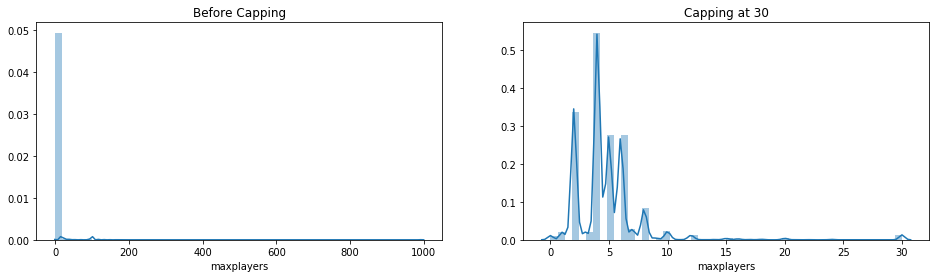

In [16]:
plt.figure(figsize = (16, 4))

plt.subplot(1, 2, 1)
sns.distplot(df.maxplayers)
plt.title("Before Capping")

plt.subplot(1, 2, 2)
sns.distplot(cleaned_df.maxplayers)
plt.title("Capping at {}".format(player_count_cap))

plt.show()

It can be seen that even adjusting the max player count to be a maximum of 30, it does not distrupt the distribution significantly. This is due to games which are limitless in the number of players making up a sliver of the data.

### Playtime

Again, typical playtime suffers when games do not necessarily have a defined end and thus could go on "forever". These games are far and few in between but I am going to cap their values to reduce how significantly they are outliers from the rest of the data. 

In [17]:
min_playtime_cap = 10 * 60 
max_playtime_cap = 20 * 60
playtime_cap = 8 * 80

max_playtime_df = cleaned_df[cleaned_df.maxplaytime > max_playtime_cap]
min_playtime_df = cleaned_df[cleaned_df.minplaytime > min_playtime_cap]
playtime_df = cleaned_df[cleaned_df.playingtime > playtime_cap]

In [18]:
print("Number of games with a max playtime above {} mins: {}".format(max_playtime_cap, len(max_playtime_df)))
print("Number of games with a min playtime above {} mins: {}".format(min_playtime_cap, len(min_playtime_df)))
print("Number of games with a playtime above {} mins: {}".format(playtime_cap, len(playtime_df)))

Number of games with a max playtime above 1200 mins: 39
Number of games with a min playtime above 600 mins: 32
Number of games with a playtime above 640 mins: 90


In [19]:
cleaned_df.maxplaytime = cleaned_df.maxplaytime.apply(lambda x : max_playtime_cap if x > max_playtime_cap else x)
cleaned_df.minplaytime = cleaned_df.minplaytime.apply(lambda x : min_playtime_cap if x > min_playtime_cap else x)
cleaned_df.playingtime= cleaned_df.playingtime.apply(lambda x : playtime_cap if x > playtime_cap else x)

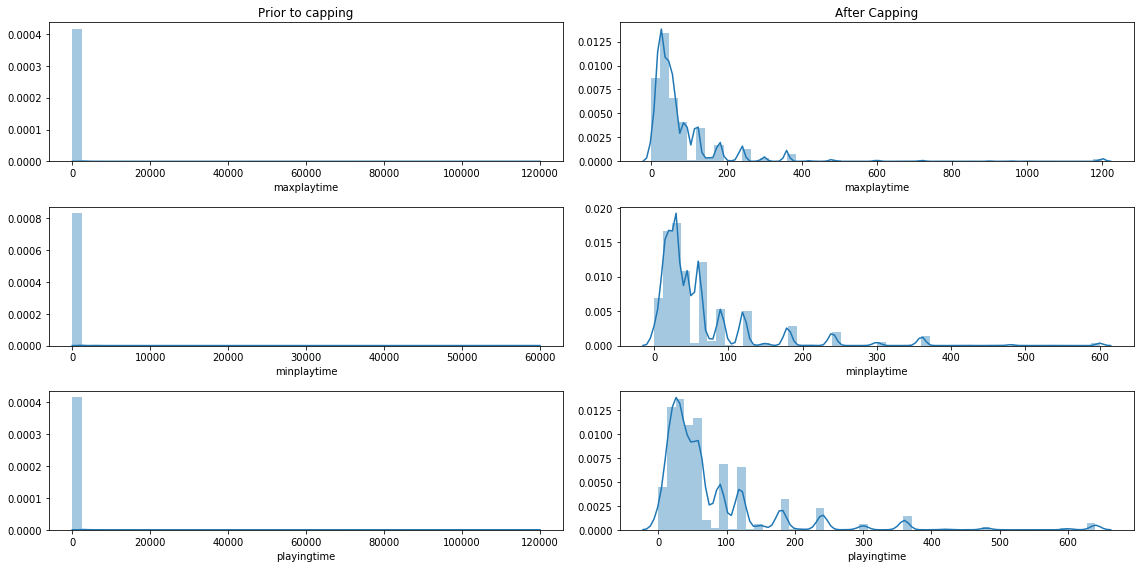

In [20]:
fig = plt.figure(figsize = (16, 8))

rows = 3
cols = 2

plt.subplot(rows, cols, 1)
sns.distplot(df.maxplaytime)
plt.title("Prior to capping")

plt.subplot(rows, cols, 2)
sns.distplot(cleaned_df.maxplaytime)
plt.title("After Capping")

plt.subplot(rows, cols, 3)
sns.distplot(df.minplaytime)


plt.subplot(rows, cols, 4)
sns.distplot(cleaned_df.minplaytime)

plt.subplot(rows, cols, 5)
sns.distplot(df.playingtime)

plt.subplot(rows, cols, 6)
sns.distplot(cleaned_df.playingtime)

plt.tight_layout()
plt.show()

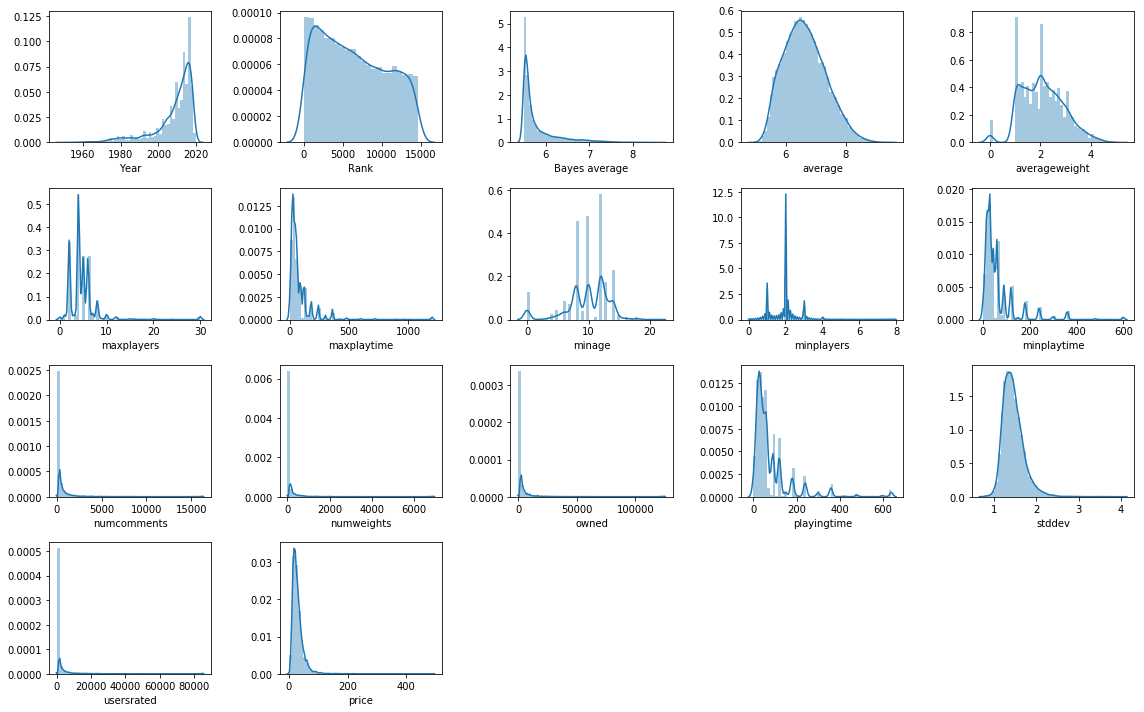

In [21]:
fig = plt.figure(figsize = (16, 10))
j = 0
for feat in features_to_examine: 
    plt.subplot(4, 5, j + 1)
    j += 1
    sns.distplot(cleaned_df[feat])
fig.tight_layout()
plt.show()

### Correlation 

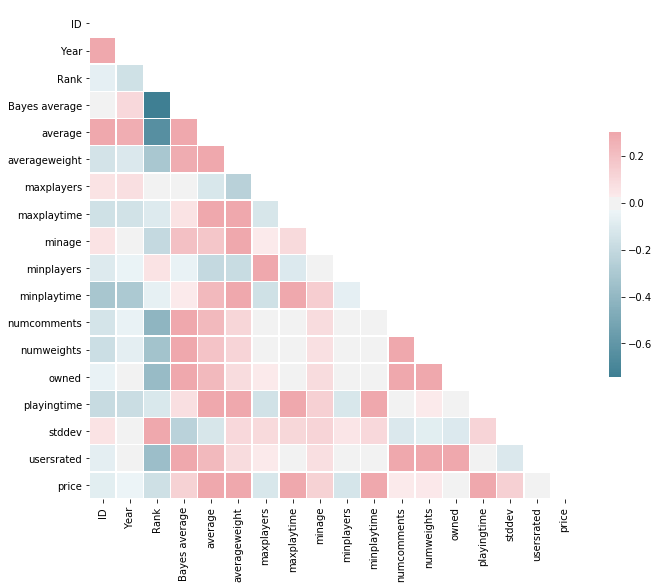

In [22]:
# Computing the correlation matrix
corr = cleaned_df.corr()

# Creating mask to cover the upper triangle
mask = np.triu(np.ones_like(corr, dtype=np.bool))

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(11, 9))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(220, 10, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, mask=mask, cmap=cmap, vmax=.3, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})

plt.show()

Can see that there is almost no strong correlation between any of the measurements, with the exception of Bayes average and Rank displaying a moderately negative correlation. 

## Investigating influence of mechanics in a game

In [23]:
no_mechanics_df = cleaned_df[cleaned_df.boardgamemechanic.isnull()]
print("Boardgames without any mechanics listed: {}".format(len(no_mechanics_df)))

Boardgames without any mechanics listed: 599


The mechanics are to be hot encoded into binary columns before being passed to the models. This makes it hard to find the mean or medium for each value. The problem with the mean is that the encoded columns will be binary, 0 or 1, so the mean will cause futher issues in the data. The median is unlikely to work either as none of the mechanisms are likely to be found in over 50% of the data, thus the median will almost definitely be zero. 

This does introduce a third option that would avoid dropping the boardgames without any mechanics, label them just as such. When encoded, each colum will describe whether or not a specific mechanic is present in each of the games. For the games with no recorded mechanics therefore, we can experiment with leaving them in the dataset but having their mechanics set as None (ie. all the columns describing mechanics will be set to zero). 

There is an obvious pro and an obvious con to this method. The benefit is that we would no lose a significant amount of data by simply deleting these datapoints. However, the drawback might be the dilution of the information brought forward about the mechanics. 

### Encoding the mechanics

In [24]:
# Changing any NaN values to an empty string, so that these games are considered simply without any of
# the listed mechanics
cleaned_df["boardgamemechanic"] = ["None" if type(x) != str else x for x in cleaned_df.boardgamemechanic]

In [25]:
# cleaning the strings describing the different mechanics so that they could be successfully seperated
cleaned_df["boardgamemechanic"] = [x.replace("\'", "") for x in cleaned_df.boardgamemechanic]
cleaned_df["boardgamemechanic"] = [x.replace("[", "") for x in cleaned_df.boardgamemechanic]
cleaned_df["boardgamemechanic"] = [x.replace("]", "") for x in cleaned_df.boardgamemechanic]
cleaned_df["boardgamemechanic"] = [x.replace(" ", "") for x in cleaned_df.boardgamemechanic]

# Producing a 1 hot encoded dataframe for the different mechanics
cleaned = cleaned_df.set_index('Name').boardgamemechanic.str.split(',', expand=True).stack()
mechanics_encoded = pd.get_dummies(cleaned, prefix='mech').groupby(level=0).sum()

mechanics_encoded = mechanics_encoded.drop("mech_None", axis = 1)

# Joining the encoded mechanics back to the original dataframe
mech_join = mechanics_encoded.reset_index()
cleaned_df = cleaned_df.merge(mech_join, on = "Name")

In [26]:
mechanics_encoded.head()

,mech_Acting,mech_Action/MovementProgramming,mech_ActionPointAllowanceSystem,mech_Area-Impulse,mech_AreaControl/AreaInfluence,mech_AreaEnclosure,mech_AreaMovement,mech_Auction/Bidding,mech_Betting/Wagering,mech_Campaign/BattleCardDriven,...,mech_Storytelling,mech_TakeThat,mech_TilePlacement,mech_TimeTrack,mech_Trading,mech_Trick-taking,mech_VariablePhaseOrder,mech_VariablePlayerPowers,mech_Voting,mech_WorkerPlacement
Name,,,,,,,,,,,,,,,,,,,,,
"""Oh My God! There's An Axe In My Head."" The Game of International Diplomacy",0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,1,0,1,1,0,0
"""Tarleton's Quarter!""",0,0,0,0,1,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
'65: Squad-Level Combat in the Jungles of Vietnam,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
*Star,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
"...and then, we held hands.",0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


#### Correlation between mechanics

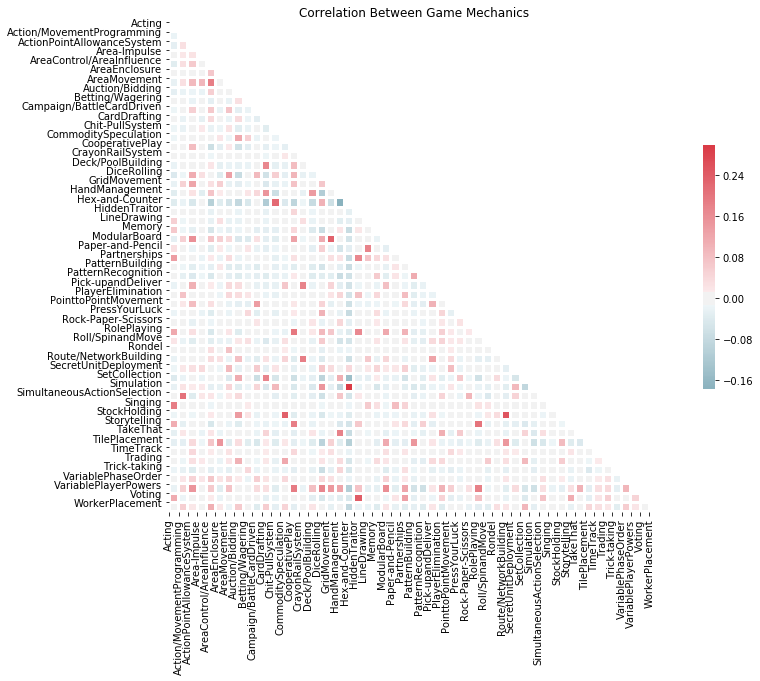

In [27]:
# Heat map of correlation 
mech_corr = mechanics_encoded.corr()
mechanic_names = [x.lstrip("mech_") for x in mechanics_encoded]
# Creating mask to cover the upper triangle
mask = np.triu(np.ones_like(mech_corr, dtype=np.bool))

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(16, 9))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(220, 10, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(mech_corr, mask=mask, cmap=cmap, vmax=.3, center=0,
            square=True, linewidths=2, cbar_kws={"shrink": .5})

plt.yticks(range(len(mechanic_names)), mechanic_names)
plt.xticks(range(len(mechanic_names)), mechanic_names, rotation = 90)
plt.title("Correlation Between Game Mechanics")
plt.show()

Whilst crowded, the heat map shows that there is very little significant correlation/overlap between any of the boardgame mechanics.

### Analysing influence of mechanics

In [28]:
# Finding and cleaning the strings associated with the mechanics
mechanics = []
for mech in cleaned_df.boardgamemechanic:
    if type(mech) == str:
        seperated_mech = mech.split(",")
        for i in seperated_mech:
            cleaned_mech = i.strip(' \'[]') 

            if cleaned_mech not in mechanics:
                mechanics.append(cleaned_mech)


In [29]:
mech_avg = np.zeros(len(mechanics))
mech_avg_std = np.zeros(len(mechanics))
mech_avg_weight = np.zeros(len(mechanics))
mech_weight_std = np.zeros(len(mechanics))
mech_count = np.zeros(len(mechanics))
mech_price = np.zeros(len(mechanics))
mech_price_std = np.zeros(len(mechanics))

for i, mech in enumerate(mechanics):
    games_of_interest = cleaned_df[cleaned_df["boardgamemechanic"].str.contains(mech)] 
    
    # find average score and its standard deviation
    mech_avg[i] = games_of_interest.average.mean()
    mech_avg_std[i] = games_of_interest.average.std()
    
    # find weight and its standard deviation
    mech_avg_weight[i] = games_of_interest.averageweight.mean()
    mech_weight_std[i] = games_of_interest.averageweight.std()

    # find count
    mech_count[i] = games_of_interest.Name.count()
    
    # find price and its standard deviation
    mech_price[i] = games_of_interest.price.mean()
    mech_price_std[i] = games_of_interest.price.std()

In [30]:
mech_df = pd.DataFrame()
mech_df["Mechanic"] = mechanics
mech_df["Average_Score"] = mech_avg
mech_df["Score_Std"] = mech_avg_std
mech_df["Average_Weight"] = mech_avg_weight
mech_df["Weight_Std"] = mech_weight_std
mech_df["Count"] = mech_count
mech_df["Price"] = mech_price
mech_df["Price_Std"] = mech_price_std

In [31]:
mech_df.head()

,Mechanic,Average_Score,Score_Std,Average_Weight,Weight_Std,Count,Price,Price_Std
0,Campaign/BattleCardDriven,7.153674,0.730107,2.708154,0.715733,299.0,43.452253,19.731737
1,CooperativePlay,6.988063,0.710745,2.183733,0.838554,710.0,33.939000,30.943682
2,GridMovement,6.956516,0.679234,2.365130,0.687687,509.0,35.195489,33.984710
3,HandManagement,6.709048,0.656233,2.039553,0.725716,2355.0,26.440530,17.181886
4,ModularBoard,6.849182,0.720622,2.392529,0.738633,914.0,35.823604,20.387222


#### Mechanics: Price

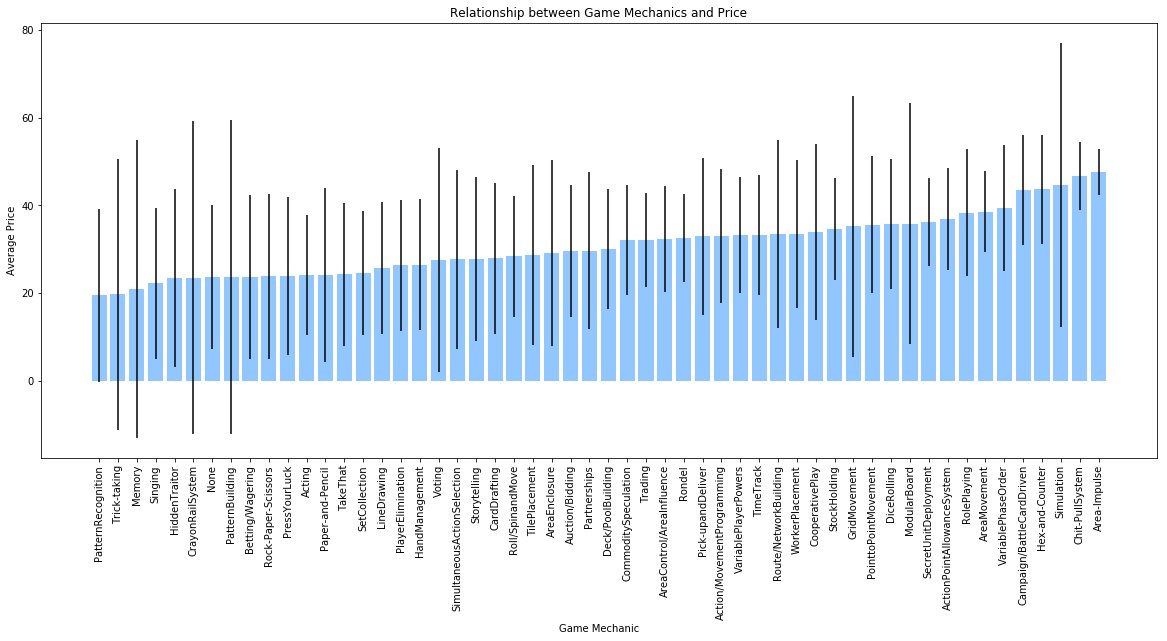

In [32]:
plt.figure(figsize = (20, 8))

plt.style.use('seaborn-pastel')
idx = np.argsort(mech_df.Price)
plt.bar(range(len(mech_df)), mech_df.Price[idx])
plt.xticks(range(len(mech_df)), np.array(mech_df.Mechanic)[idx], rotation = 90)
plt.errorbar(x = range(len(mech_df)), y = mech_df.Price[idx], yerr = mech_df.Price_Std, c = 'k', linestyle = "None")
plt.xlabel("Game Mechanic")
plt.ylabel("Average Price")
plt.title("Relationship between Game Mechanics and Price")
plt.show()

#### Mechanics: Score

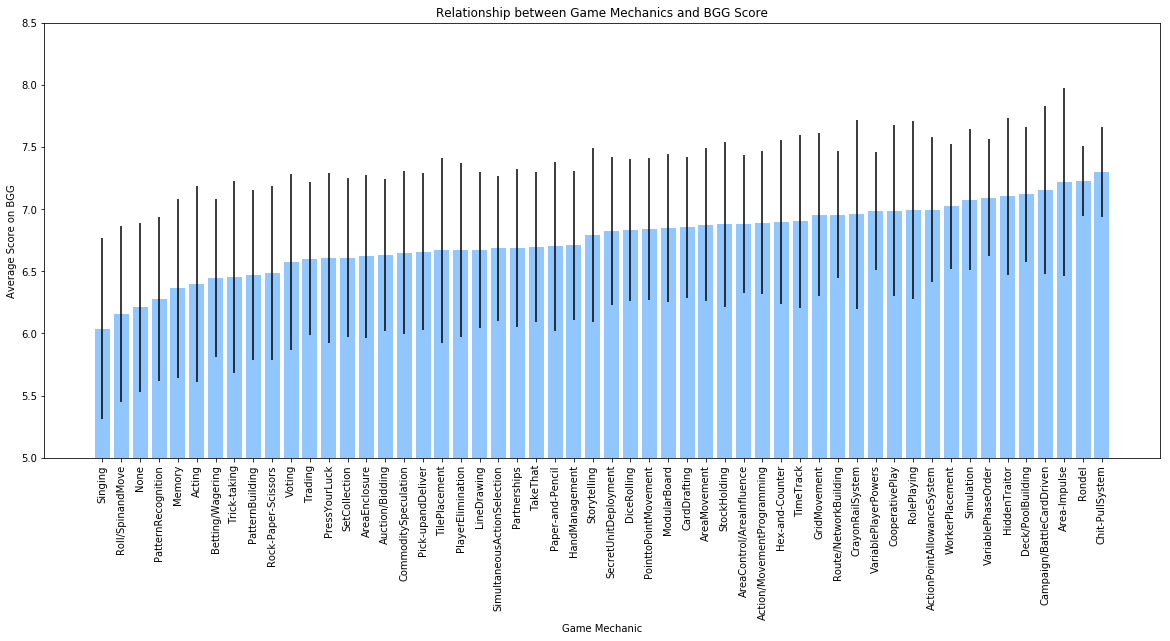

In [33]:
plt.figure(figsize = (20, 8))

plt.style.use('seaborn-pastel')
idx = np.argsort(mech_df.Average_Score)
plt.bar(range(len(mech_df)), mech_df.Average_Score[idx])
plt.xticks(range(len(mech_df)), np.array(mech_df.Mechanic)[idx], rotation = 90)
plt.errorbar(x = range(len(mech_df)), y = mech_df.Average_Score[idx], yerr = mech_df.Score_Std, c = 'k', linestyle = "None")
plt.xlabel("Game Mechanic")
plt.ylabel("Average Score on BGG")
plt.title("Relationship between Game Mechanics and BGG Score")
plt.ylim(5, 8.5)
plt.show()

#### Mechanics: Weight

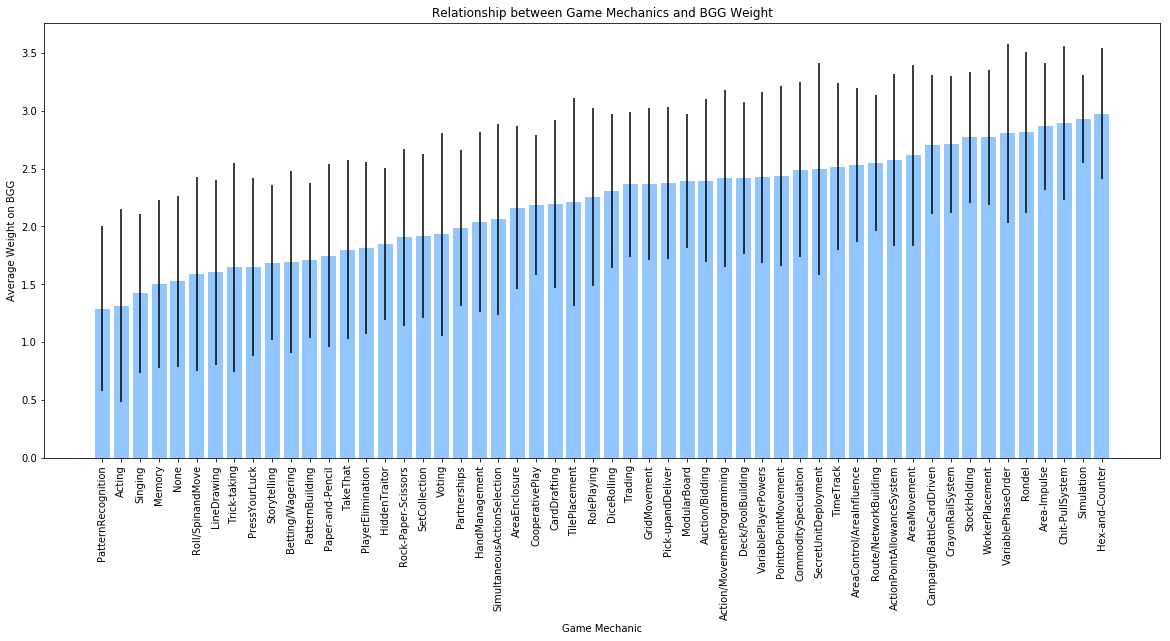

In [34]:
plt.figure(figsize = (20, 8))

idx = np.argsort(mech_df.Average_Weight)
plt.bar(range(len(mech_df)), mech_df.Average_Weight[idx])
plt.errorbar(x = range(len(mech_df)), y = mech_df.Average_Weight[idx], yerr = mech_df.Weight_Std, c = 'k', linestyle = "None")
plt.xticks(range(len(mech_df)), np.array(mech_df.Mechanic)[idx], rotation = 90)

plt.xlabel("Game Mechanic")
plt.ylabel("Average Weight on BGG")
plt.title("Relationship between Game Mechanics and BGG Weight")


plt.show()

It can be seen that the standard deviation of the price, weight and score across different mechanics is massive. This has the potential side effect of weakening any models applied to this data.

#### Mechanics: Count

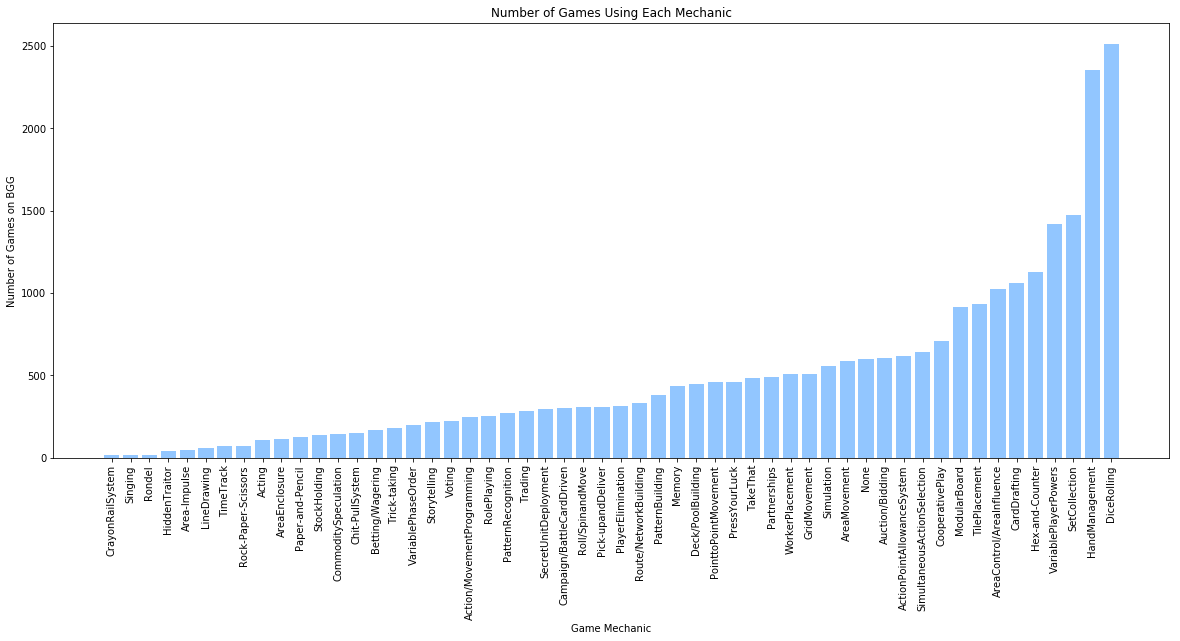

In [35]:
plt.figure(figsize = (20, 8))

idx = np.argsort(mech_df.Count)
plt.bar(range(len(mech_df)), mech_df.Count[idx])
plt.xticks(range(len(mech_df)), np.array(mech_df.Mechanic)[idx], rotation = 90)

plt.xlabel("Game Mechanic")
plt.ylabel("Number of Games on BGG")
plt.title("Number of Games Using Each Mechanic")


plt.show()

# Price predictor: 

Multiple SciKit-Learn models will be experimented with to investigate the datasets potential to predict the price of the game in question. 

In [36]:
# Data Scaling
from sklearn.preprocessing import StandardScaler, MinMaxScaler

# Models
from sklearn.ensemble import RandomForestRegressor
from sklearn.neural_network import MLPRegressor

# Error Metrics
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error as mse

# Hyper Parameter Tuning
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV

# For Parameter Printing
from pprint import pprint

#### Splitting the data into train, validation and test

Splitting the data into training and testing

In [38]:
ml_data = cleaned_df.copy()
# Removing the name and ID 
ml_data = ml_data.drop(["Name", "ID", "boardgamemechanic"], axis = 1)

##### Correlation between measurements

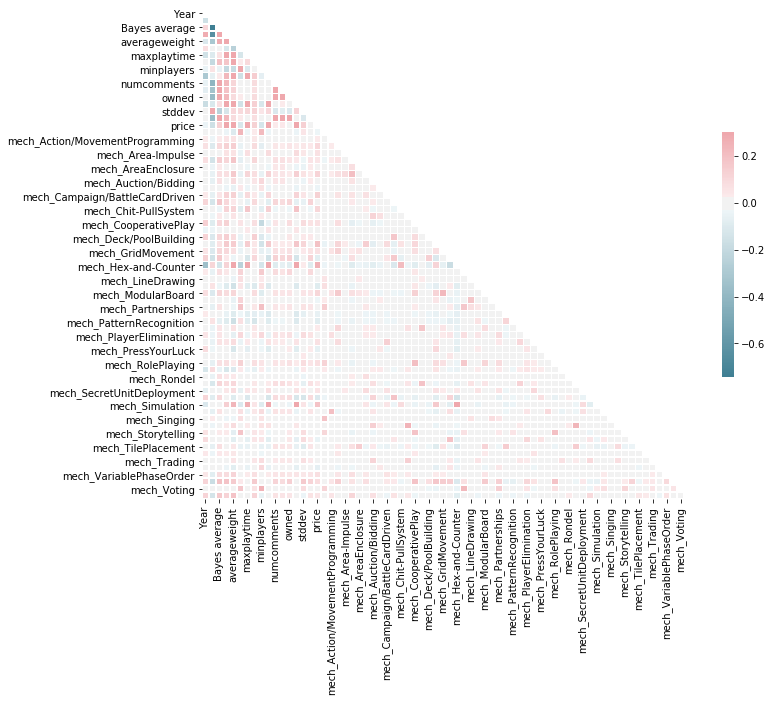

In [39]:
# Computing the correlation matrix
corr = ml_data.corr()

# Creating mask to cover the upper triangle
mask = np.triu(np.ones_like(corr, dtype=np.bool))

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(11, 9))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(220, 10, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, mask=mask, cmap=cmap, vmax=.3, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})

plt.show()

It can be seen that whilst some values have a degree of negative correlation (e.g. rank and price, or rank and average score), none of the measurements are sufficiently correlated (>0.9) for it to be worthwhile to remove any measurements.

In [40]:
X = ml_data.copy().drop("price", axis = 1)
Y = ml_data.price

# Splitting into training and testing
x_train, x_test, y_train, y_test = train_test_split(X, Y, test_size = 0.33)

y_train = y_train.reshape(-1, 1)
y_test = y_test.reshape(-1, 1)

C:\Users\Laurence\Anaconda3\lib\site-packages\ipykernel_launcher.py:7: FutureWarning: reshape is deprecated and will raise in a subsequent release. Please use .values.reshape(...) instead
  import sys
C:\Users\Laurence\Anaconda3\lib\site-packages\ipykernel_launcher.py:8: FutureWarning: reshape is deprecated and will raise in a subsequent release. Please use .values.reshape(...) instead
  


### Neural Network:

In [41]:
# Scaling the data for mlp
# Initialising and fitting scalers
scalerx = MinMaxScaler()
scalery = MinMaxScaler()




scalerx.fit(x_train)
scalery.fit(y_train.reshape(-1, 1))

# Scaling x-data
x_train_scaled = scalerx.transform(x_train)
x_test_scaled = scalerx.transform(x_test)

# Scaling y-data
y_train_scaled = scalery.transform(y_train)
y_test_scaled = scalery.transform(y_test)

#### Tuning MLP

In [42]:
mlp_parameters = {
    'hidden_layer_sizes': [(4), (4, 4), (8, 8), (16, 16), (25, 16, 8, 4)],
    'activation': ['relu', 'tanh'],
    'solver': ['sgd', 'adam'],
    'alpha': [0.0001, 0.05],
    'learning_rate': ['constant','adaptive'],
}

In [43]:
mlp = MLPRegressor()
#mlp_search = RandomizedSearchCV(estimator = mlp, param_distributions = mlp_parameters, 
#                               n_iter = 4, cv = 3, verbose=0, random_state=42)

mlp_search = GridSearchCV(mlp, mlp_parameters)
mlp_search.fit(x_train_scaled, y_train_scaled.reshape(-1,))

GridSearchCV(cv=None, error_score='raise',
       estimator=MLPRegressor(activation='relu', alpha=0.0001, batch_size='auto', beta_1=0.9,
       beta_2=0.999, early_stopping=False, epsilon=1e-08,
       hidden_layer_sizes=(100,), learning_rate='constant',
       learning_rate_init=0.001, max_iter=200, momentum=0.9,
       nesterovs_momentum=True, power_t=0.5, random_state=None,
       shuffle=True, solver='adam', tol=0.0001, validation_fraction=0.1,
       verbose=False, warm_start=False),
       fit_params=None, iid=True, n_jobs=1,
       param_grid={'hidden_layer_sizes': [4, (4, 4), (8, 8), (16, 16), (25, 16, 8, 4)], 'activation': ['relu', 'tanh'], 'solver': ['sgd', 'adam'], 'alpha': [0.0001, 0.05], 'learning_rate': ['constant', 'adaptive']},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=0)

In [44]:
mlp_opt = mlp_search.best_estimator_
pprint(mlp_opt.get_params())

{'activation': 'tanh',
 'alpha': 0.05,
 'batch_size': 'auto',
 'beta_1': 0.9,
 'beta_2': 0.999,
 'early_stopping': False,
 'epsilon': 1e-08,
 'hidden_layer_sizes': (16, 16),
 'learning_rate': 'adaptive',
 'learning_rate_init': 0.001,
 'max_iter': 200,
 'momentum': 0.9,
 'nesterovs_momentum': True,
 'power_t': 0.5,
 'random_state': None,
 'shuffle': True,
 'solver': 'adam',
 'tol': 0.0001,
 'validation_fraction': 0.1,
 'verbose': False,
 'warm_start': False}


In [45]:
y_train_pred_scaled = mlp_opt.predict(x_train_scaled)
y_train_pred = scalery.inverse_transform(y_train_pred_scaled.reshape(-1, 1))

y_test_pred_scaled = mlp_opt.predict(x_test_scaled)
y_test_pred = scalery.inverse_transform(y_test_pred_scaled.reshape(-1, 1))

mlp_train_rmse = np.sqrt(mse(y_train, y_train_pred))
mlp_test_rmse = np.sqrt(mse(y_test, y_test_pred))

mlp_train_mae = mean_absolute_error(y_train, y_train_pred)
mlp_test_mae = mean_absolute_error(y_test, y_test_pred)


print("Root Mean Squared Error of best estimator:")
print("Train: £{}".format(round(mlp_train_rmse, 4)))
print("Test: £{}".format(round(mlp_test_rmse, 4)))
print(" ")
print("Mean Absolute Error of best estimator:")
print("Train: £{}".format(round(mlp_train_mae, 4)))
print("Test: £{}".format(round(mlp_test_mae, 4)))

Root Mean Squared Error of best estimator:
Train: £15.8836
Test: £17.0564
 
Mean Absolute Error of best estimator:
Train: £10.0892
Test: £10.2694


### Random Forest

#### Hyper parameter Tuning: 

In [46]:
max_depth = [x for x in np.linspace(10, 110, num = 11)]
max_depth.append(None)
rf_parameters = {'n_estimators': list(int(x) for x in np.linspace(start = 50, stop = 300, num = 6)),
               'max_features': ['auto', 'sqrt'],
               'max_depth':  max_depth,
               'min_samples_split': [2, 5, 10],
               'min_samples_leaf': [1, 2, 4],
              }

In [49]:
rf = RandomForestRegressor()
rf_search = RandomizedSearchCV(estimator = rf, param_distributions = rf_parameters, 
                               n_iter = 20 , random_state=42)
#rf_search = GridSearchCV(rf, rf_parameters)
#
rf_search.fit(x_train, y_train.reshape(-1, ))

RandomizedSearchCV(cv=None, error_score='raise',
          estimator=RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
           oob_score=False, random_state=None, verbose=0, warm_start=False),
          fit_params=None, iid=True, n_iter=20, n_jobs=1,
          param_distributions={'n_estimators': [50, 100, 150, 200, 250, 300], 'max_features': ['auto', 'sqrt'], 'max_depth': [10.0, 20.0, 30.0, 40.0, 50.0, 60.0, 70.0, 80.0, 90.0, 100.0, 110.0, None], 'min_samples_split': [2, 5, 10], 'min_samples_leaf': [1, 2, 4]},
          pre_dispatch='2*n_jobs', random_state=42, refit=True,
          return_train_score='warn', scoring=None, verbose=0)

In [50]:
rf_opt = rf_search.best_estimator_
pprint(rf_opt.get_params())

{'bootstrap': True,
 'criterion': 'mse',
 'max_depth': 70.0,
 'max_features': 'sqrt',
 'max_leaf_nodes': None,
 'min_impurity_decrease': 0.0,
 'min_impurity_split': None,
 'min_samples_leaf': 2,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 250,
 'n_jobs': 1,
 'oob_score': False,
 'random_state': None,
 'verbose': 0,
 'warm_start': False}


In [51]:
rf_train_pred = rf_opt.predict(x_train)
rf_test_pred = rf_opt.predict(x_test)

In [52]:
rf_train_rmse = np.sqrt(mse(rf_train_pred, y_train))
rf_test_rmse = np.sqrt(mse(rf_test_pred, y_test))

rf_train_mae = mean_absolute_error(rf_train_pred, y_train)
rf_test_mae = mean_absolute_error(rf_test_pred,  y_test)

print("Root Mean Squared Error: ")
print("Train: £{}".format(round(rf_train_rmse, 4)))
print("Test: £{}".format(round(rf_test_rmse, 4)))
print(" ")
print("Mean Absolute Error: ")
print("Train: £{}".format(round(rf_train_mae, 4)))
print("Test: £{}".format(round(rf_test_mae, 4)))

Root Mean Squared Error: 
Train: £9.4545
Test: £16.4614
 
Mean Absolute Error: 
Train: £5.336
Test: £9.5786


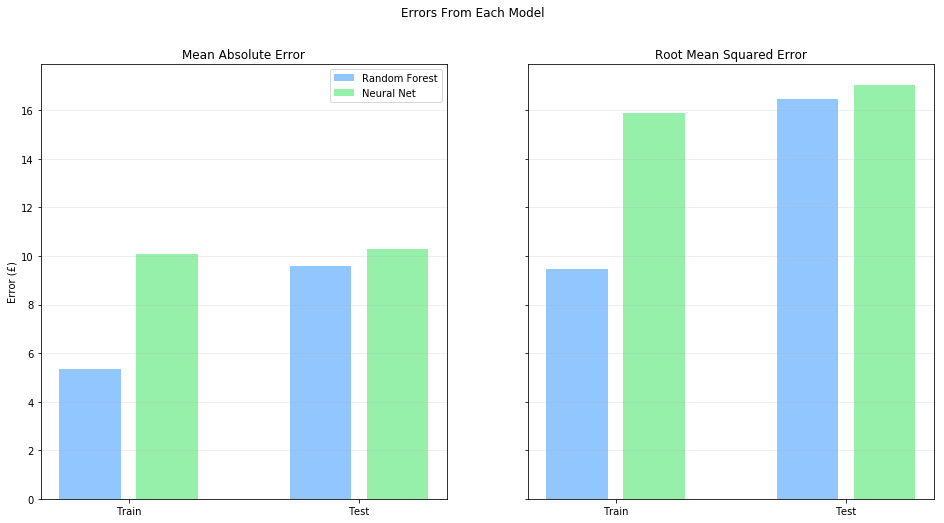

In [53]:
alpha_val = 0.25
fig, [ax1, ax2] = plt.subplots(1, 2, sharey = True, figsize = (16, 8))

ax1.set_title("Mean Absolute Error")
ax1.bar([1, 4], [rf_train_mae, rf_test_mae], label = "Random Forest")
ax1.bar([2, 5], [mlp_train_mae, mlp_test_mae], label = "Neural Net")
ax1.set_xticks([1.5, 4.5])
ax1.set_xticklabels(["Train", "Test"])
ax1.legend()
ax1.grid(alpha = alpha_val, axis = 'y')
ax1.set_ylabel("Error (£)")
ax2.set_title("Root Mean Squared Error")
ax2.bar([1, 4], [rf_train_rmse, rf_test_rmse], label = "RF")
ax2.bar([2, 5], [mlp_train_rmse, mlp_test_rmse], label = "NN")
ax2.set_xticks([1.5, 4.5])
ax2.set_xticklabels(["Train", "Test"])
ax2.grid(alpha = alpha_val, axis = 'y')

plt.suptitle("Errors From Each Model")
plt.show()


### Outcome and Conclusion:

It has been an interesting project and I feel like I have learnt some both major and minor lessons which I had not considered before in this sort of project, with three sticking clearly in my mind.

Firstly, the fact that ethically webscraping can be a long process if amount of information per request is low. I did not want to put any unnecessary strain on boardgameprices.co.uk and so the webscraping for 1000s of games took days. In retrospect, I could have probably collected fewer data and still acheived a similar level of accuracy in the predictive models. 

Taking for granted any aspect of the data's distribution. Whilst obvious, this projected acted as a gentle reminder of the importance of thoroughly cleaning one's data. In particular, metrics such as the maximum number of players were distributed wildly with some games having a maximum player count of 1000! 

And thirdly, the many different methods of encoding categorical data at your disposal when formatting a dataset. With around 50 different boardgame mechanics found in the dataset, I had to consider the impact that adding that many dimensions to a dataset might have. Whilst I eventually just settled for one-hot encoding, it was an educational experience to investigate the different options out there. 
